#### This code plots the processed Baysor segmentation over an FOV for validation
##### This code uses timecourse_env_01 as the anaconda environment

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import glob
import alphashape
import geopandas as gpd
import seaborn as sns
from shapely.ops import transform
from shapely.affinity import scale
import imageio as io
import tifffile as tiff
import imagecodecs
import shapely.affinity as sa
import json
from core_functions.segmentation_evaluation import *

In [2]:
data_dir = 'D:/amonell/timecourse_replicates'

In [3]:
input_folders = glob.glob(os.path.join(data_dir, 'day*'))

#### Plotting Segmentation on an FOV

In [4]:
minx=8000
miny=20000
maxx=10000
maxy=21000

  0%|          | 0/4 [00:00<?, ?it/s]

D:/amonell/timecourse_replicates\day30_SI_r2
Finished reading in adata and transcripts
Subsetting FOV
Making Shapes
Plotting
Figures dir already exists
Segmentation_Evaluation dir already exists


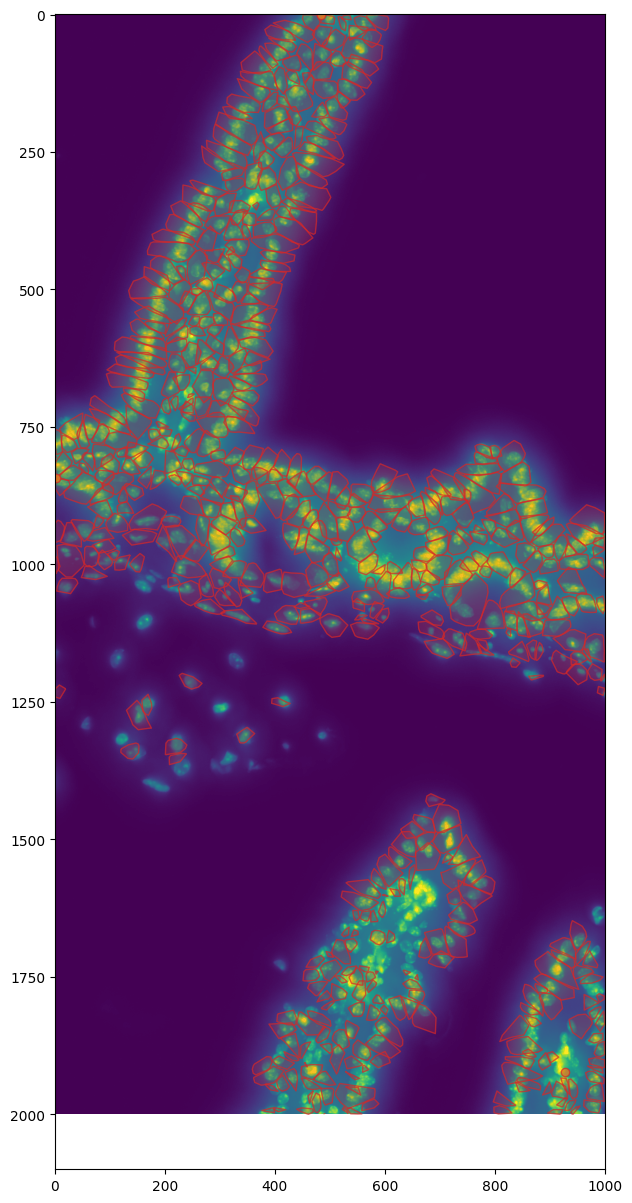

D:/amonell/timecourse_replicates\day6_SI_r2
Finished reading in adata and transcripts
Subsetting FOV
Making Shapes
Plotting
Figures dir already exists
Segmentation_Evaluation dir already exists


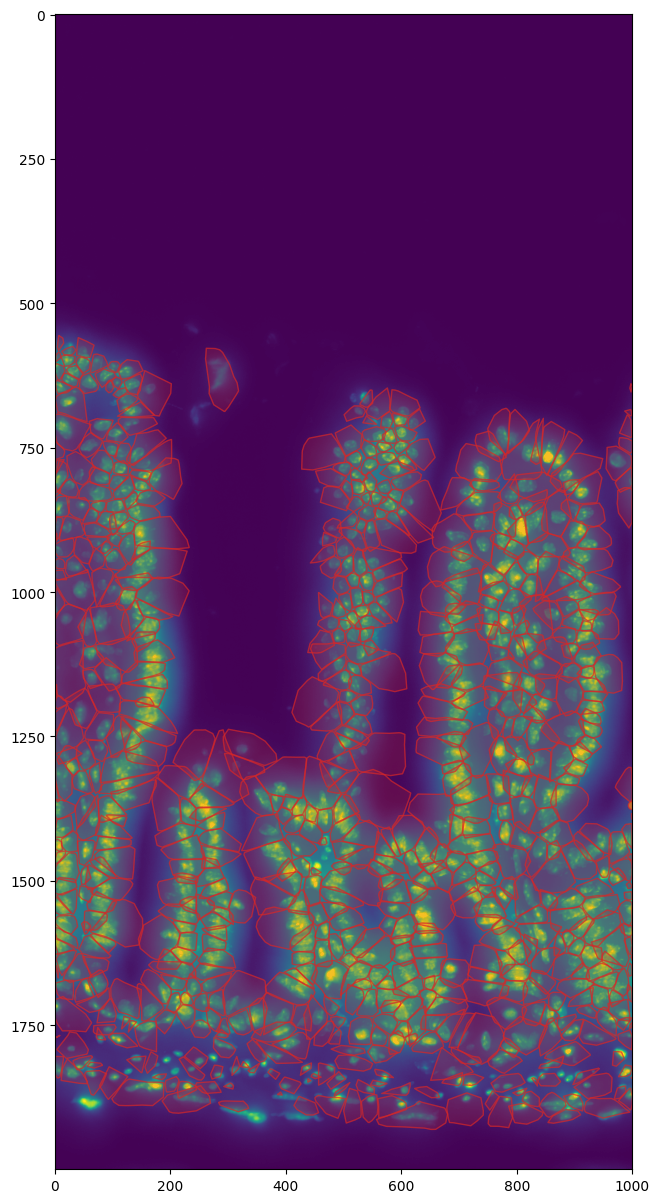

D:/amonell/timecourse_replicates\day8_SI_r2
Finished reading in adata and transcripts
Subsetting FOV
Making Shapes
Plotting
Figures dir already exists
Segmentation_Evaluation dir already exists


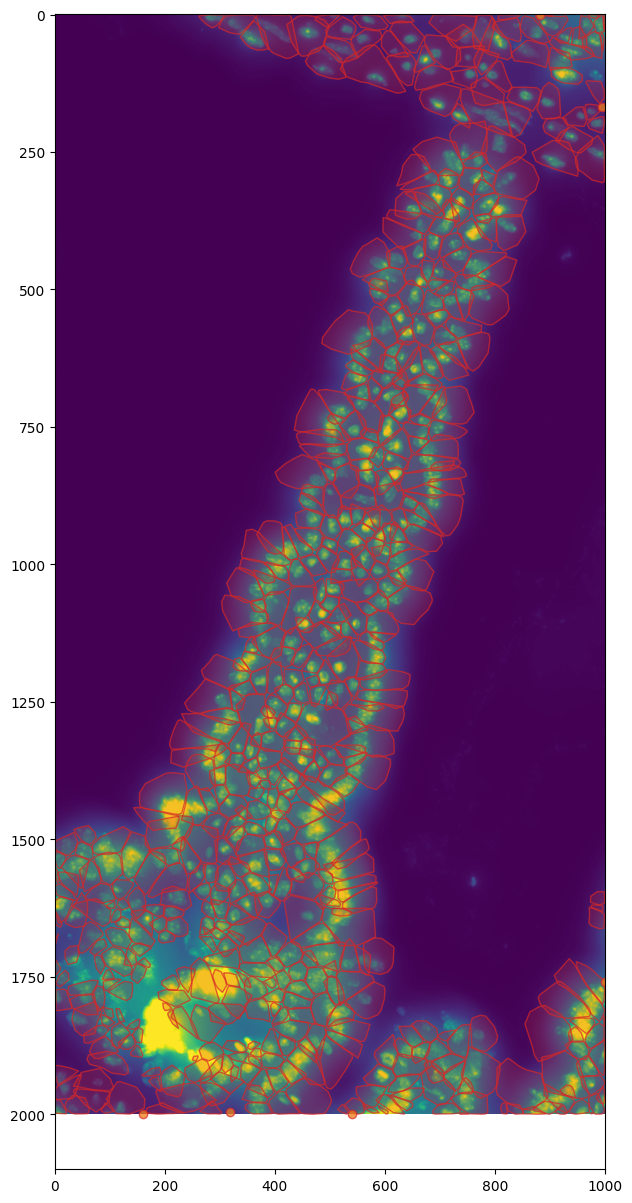

D:/amonell/timecourse_replicates\day90_SI_r2
Finished reading in adata and transcripts
Subsetting FOV
Making Shapes
Plotting
Figures dir already exists
Segmentation_Evaluation dir already exists


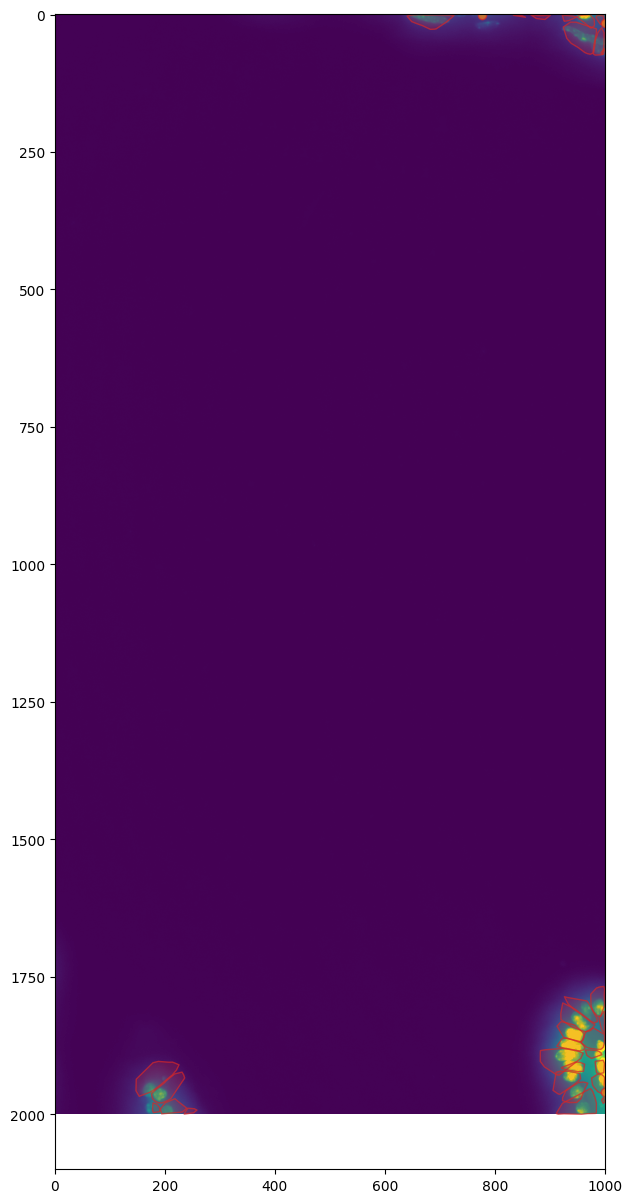

In [7]:
for input_file in tqdm(input_folders):
    print(input_file)
    adata = sc.read(os.path.join(input_file, 'adatas', '01_preprocessed.h5ad'))
    xenium_output_path = os.path.join(input_file, 'xenium_output')
    baysor_transcripts = adata.uns['points'] 
    print('Finished reading in adata and transcripts')
    pixel_size = get_pixel_size(xenium_output_path)
    print('Subsetting FOV')
    transcript_subset_fov = subset_transcripts_file(baysor_transcripts, pixel_size, minx, maxx, miny, maxy)

    img = import_image(xenium_output_path)

    print('Making Shapes')
    shapes = transcript_subset_fov[(transcript_subset_fov.split_cell != 0) & (transcript_subset_fov.split_cell != -1)].groupby("split_cell")[['x', 'y']].apply(make_alphashape, alpha=0.05)
    shapes = gpd.GeoSeries(shapes)

    def scale_to_image(x, y):
        return(x/pixel_size, y/pixel_size)
        
    colors = sns.color_palette()[3]
    shapes2 = shapes.apply(lambda x: transform(scale_to_image, x))
    
    print('Plotting')
    fig, ax = plt.subplots(1, 1, figsize = (15,15))
    img_cropped=img[minx:maxx, miny:maxy]
    ax.imshow(
        img_cropped, 
        vmax=np.percentile(img_cropped, 99.9)
    )
    # Create an empty GeoDataFrame to store adjusted polygons
    adjusted_shapes = []
    
    # Iterate through the shapes DataFrame and adjust each polygon
    for original_polygon in shapes2:
        scaled_polygon = sa.translate(original_polygon, -miny, -minx)
        adjusted_shapes.append(scaled_polygon)
        
    adjusted_shapes =gpd.GeoSeries(adjusted_shapes)
    
    # Plot the adjusted polygons
    adjusted_shapes.plot(facecolor=colors, edgecolor='none', alpha=0.2, ax=ax)
    adjusted_shapes.plot(facecolor="none", edgecolor=colors, alpha=0.7,  ax=ax)
    ax.set_xlim((0, 1000))
    # ax.set_ylim((1500, 500))
    #plt.scatter((transcript_subset_fov.x.values/pixel_size) - miny, (transcript_subset_fov.y.values/pixel_size) - minx, s=1, linewidths=0.01, alpha=0.5, c='white')
    try: 
        os.mkdir(os.path.join(input_file, 'figures'))
    except:
        print('Figures dir already exists')
    try: 
        os.mkdir(os.path.join(input_file, 'figures', 'Segmentation_Evaluation'))
    except:
        print('Segmentation_Evaluation dir already exists')
    plt.savefig(os.path.join(input_file, 'figures', 'Segmentation_Evaluation', 'baysor_refined_segmentation_fov_example.png'))
    plt.show()

## Plotting a single FOV

In [65]:
minx=24000
miny=20500
maxx=25000
maxy=21500

Finished reading in adata and transcripts
Subsetting FOV
Making Shapes
Plotting


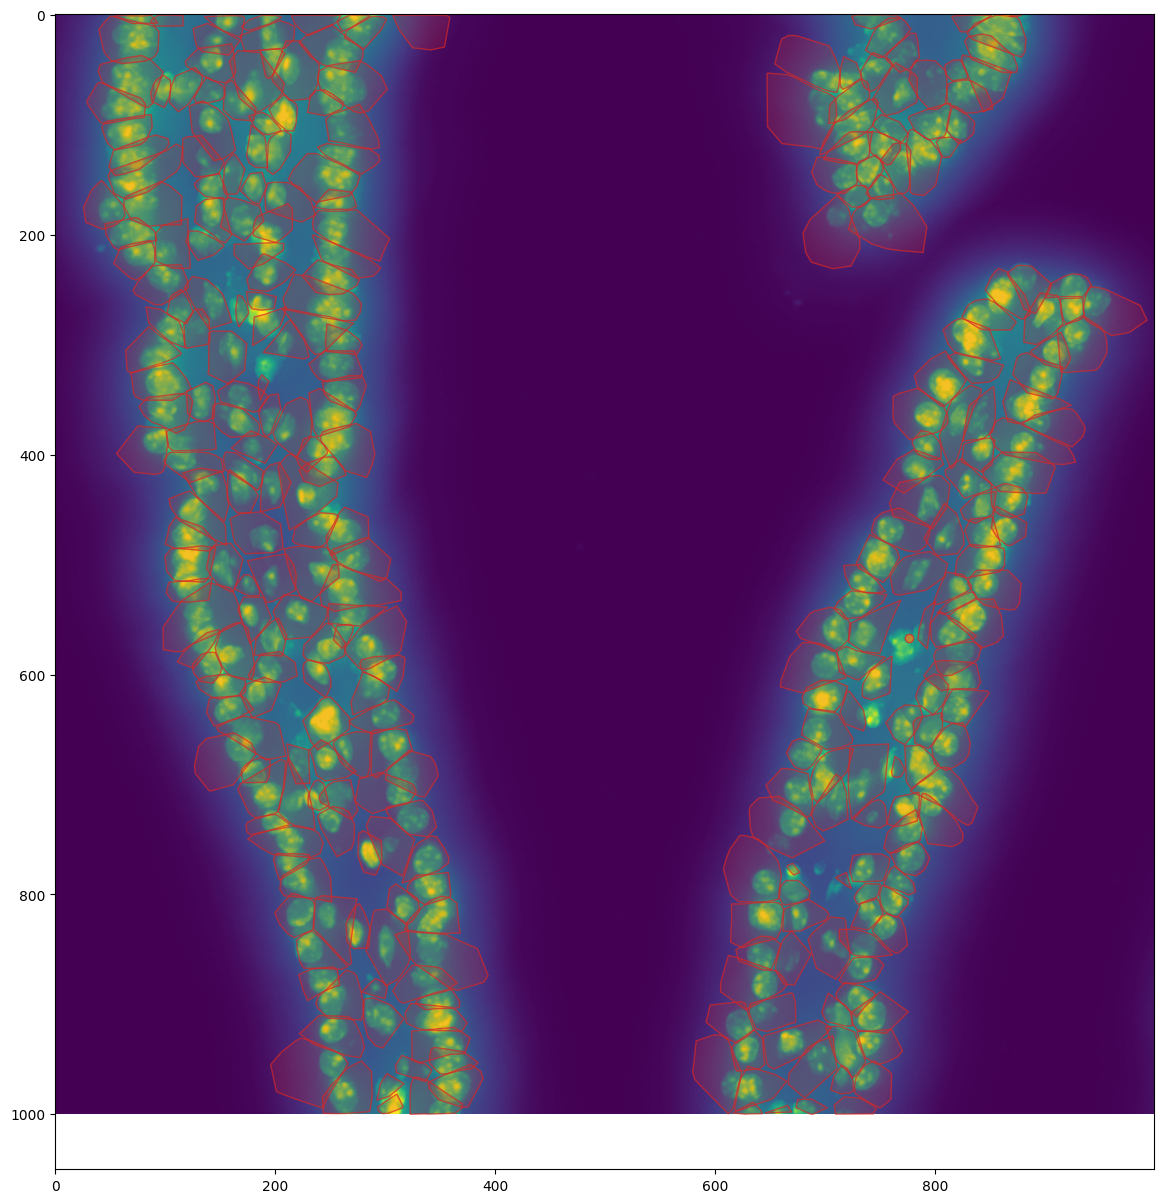

In [70]:
baysor_transcripts = adata.uns['points'] 
print('Finished reading in adata and transcripts')
pixel_size = get_pixel_size(xenium_output_path)
print('Subsetting FOV')
transcript_subset_fov = subset_transcripts_file(baysor_transcripts, pixel_size, minx, maxx, miny, maxy)

img = import_image(xenium_output_path)

print('Making Shapes')
shapes = transcript_subset_fov[(transcript_subset_fov.split_cell != 0) & (transcript_subset_fov.split_cell != -1)].groupby("split_cell")[['x', 'y']].apply(make_alphashape, alpha=0.05)
shapes = gpd.GeoSeries(shapes)

def scale_to_image(x, y):
    return(x/pixel_size, y/pixel_size)
    
colors = sns.color_palette()[3]
shapes2 = shapes.apply(lambda x: transform(scale_to_image, x))

print('Plotting')
fig, ax = plt.subplots(1, 1, figsize = (15,15))
img_cropped=img[minx:maxx, miny:maxy]
ax.imshow(
    img_cropped, 
    vmax=np.percentile(img_cropped, 99.9)
)
# Create an empty GeoDataFrame to store adjusted polygons
adjusted_shapes = []

# Iterate through the shapes DataFrame and adjust each polygon
for original_polygon in shapes2:
    scaled_polygon = sa.translate(original_polygon, -miny, -minx)
    adjusted_shapes.append(scaled_polygon)
    
adjusted_shapes =gpd.GeoSeries(adjusted_shapes)

adjusted_shapes.plot(facecolor=colors, edgecolor='none', alpha=0.2, ax=ax)
adjusted_shapes.plot(facecolor="none", edgecolor=colors, alpha=0.7,  ax=ax)

spots = transcript_subset_fov[(transcript_subset_fov.split_cell != 0) & (transcript_subset_fov.split_cell != -1)].groupby("split_cell")[['x', 'y']]
colors = np.random.rand(len(spots), 3)  # Generates random RGB colors

# Create a scatter plot with random colors
ct_col = 0
#for spg in spots:
#    ax.scatter(spg[1].x/pixel_size - miny, spg[1].y/pixel_size - minx, c=[colors[ct_col]], s=17)
#    ct_col+=1

plt.savefig(os.path.join(input_file, 'figures', 'Segmentation_Evaluation', 'baysor_refined_segmentation_fov_example.png'))
#ax.set_xlim((0, 1000))
plt.show()

In [69]:
input_file

'D:/amonell/timecourse_final\\day7_SI_DMSO'